# Tutorial [Raytracing em um final de semana](https://raytracing.github.io/books/RayTracingInOneWeekend.html#rays,asimplecamera,andbackground)

Observações: 

- As **etapas 1 e 2** estão implementadas no diretório **Atividade 01**

- A **etapa 3** está implementada em **Atividade 02**

- A **etapa 4.1** está implementada em **Ray.py** no mesmo repositório

## Importações

In [1]:
import sys
import os

import numpy as np
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join('..')))

from Ray import Ray
from Atividade02.src.vectorized.Vec3 import Vec3, Point3, Color
from Atividade01.src.ImageIO import ImageWriter
from Atividade01.src.Image import Image

## 4.2 Sending Rays Into the scene 

In [2]:
aspect_ratio = 16.0 / 9.0
image_width = 400

image_height = int(image_width / aspect_ratio)
if image_height < 1:
    image_height = 1

viewport_height = 2.0
viewport_width = viewport_height * (image_width / image_height)
# OBS: viewport_width: não está usando a variável aspect_ratio, pois a variável aspect_ratio é a proporção ideal da imagem, porém, arredondamos image_height para inteiro, podendo assim perder um pouco de precisão na proporção da imagem.


  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [00:12<00:00, 18.45it/s]


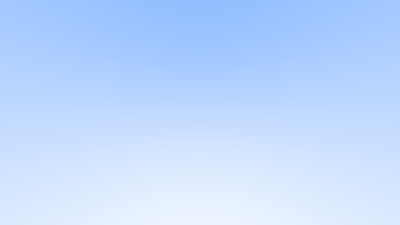

In [3]:
def ray_color(ray: Ray):
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

def raytrace_pipeline(filename: str):
    aspect_ratio = 16.0 / 9.0
    image_width = 400

    image_height = int(image_width / aspect_ratio)
    if image_height < 1:
        image_height = 1

    viewport_height = 2.0
    viewport_width = viewport_height * (image_width / image_height)
    
    focal_length = 1.0
    camera_center = Point3([0, 0, 0])

    viewport_u = Vec3([viewport_width, 0, 0])
    viewport_v = Vec3([0, -viewport_height, 0])

    pixel_delta_u = viewport_u / image_width
    pixel_delta_v = viewport_v / image_height

    # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
    # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

    viewport_upper_left = camera_center - Vec3([0, 0, focal_length]) - (viewport_u / 2) - (viewport_v / 2)
    pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)
    # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.


    # CRIAR MATRIZ
    image = Image(image_width, image_height)
    for j in tqdm(range(image_height)):
        for i in range(image_width):
            pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
            ray_direction = pixel_center - camera_center
            ray = Ray(camera_center, ray_direction)

            pixel_color = ray_color(ray)
            image[j, i] = pixel_color

    img_writer = ImageWriter(image)
    img_writer.save(filename)
    display(img_writer.image)

raytrace_pipeline('1-degrade-raytrace.png')
# A imagem sairá com degradê para os dois lados, pois está utilizando o vetor unidade, e não o próprio y diretamente
# Logo, as outras coordenadas (x e z) influenciam no vetor unidade, fazendo com que o y não seja o unico vetor que influencia na cor.

## 5.2 Creating Our First Raytraced Image

100%|██████████| 225/225 [00:14<00:00, 16.04it/s]


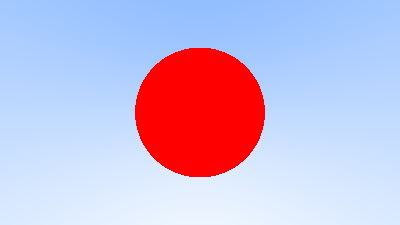

In [4]:
def hit_sphere(center: Point3, radius: float, ray: Ray):
    oc = ray.origin - center
    a = ray.direction.dot(ray.direction)
    b = 2 * oc.dot(ray.direction)
    c = oc.dot(oc) - radius ** 2

    discriminant = b ** 2 - 4 * a * c
    return discriminant >= 0

def ray_color(ray: Ray):
    # Se acertar a esfera, pinta de vermelho
    if hit_sphere(Point3([0, 0, -1]), 0.5, ray):
        return Color([1, 0, 0])
    
    # Se não, pinta com o fundo (degradê)
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

raytrace_pipeline('2-first-sphere.png')

## 6.1 Shading with Surface Normals

100%|██████████| 225/225 [00:13<00:00, 17.19it/s]


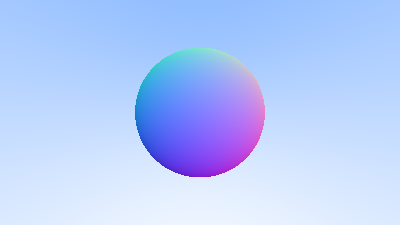

In [5]:
def hit_sphere(center: Point3, radius: float, ray: Ray):
    oc = ray.origin - center
    a = ray.direction.dot(ray.direction)
    b = 2 * oc.dot(ray.direction)
    c = oc.dot(oc) - radius ** 2

    discriminant = b ** 2 - 4 * a * c

    if discriminant < 0:
        return -1
    else:
        return (-b -np.sqrt(discriminant)) / (2.0 * a)

def ray_color(ray: Ray):
    # Se acertar a esfera, pinta de vermelho
    t = hit_sphere(Point3([0, 0, -1]), 0.5, ray)
    if t > 0:
        normal = (ray.at(t) - Vec3([0, 0, -1])).unit_vector()
        return 0.5 * Color([normal.x + 1, normal.y + 1, normal.z + 1])
    
    # Se não, pinta com o fundo (degradê)
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

raytrace_pipeline('3-sphere-with-normals.png')

## 6.2 Simplifying the Ray-Sphere Intersection Code

100%|██████████| 225/225 [00:12<00:00, 17.65it/s]


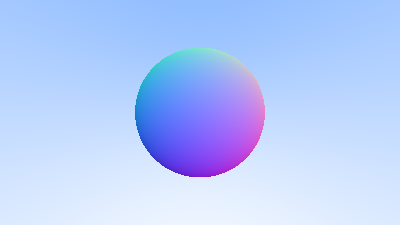

In [6]:
def hit_sphere(center: Point3, radius: float, ray: Ray):
    oc = ray.origin - center
    a = ray.direction.squared_length()
    half_b = oc.dot(ray.direction)
    c = oc.dot(oc) - radius ** 2

    discriminant = half_b ** 2 - a * c

    if discriminant < 0:
        return -1
    else:
        return (-half_b -np.sqrt(discriminant)) / a

raytrace_pipeline('4-simplified-sphere.png')

## 6.3 An Abstraction for Hittable Objects

In [7]:

class HitRecord:

    def __init__(self, p: Point3, normal: Vec3, t: float):
        self.p = p
        self.normal = normal
        self.t = t


class Hittable:

    def hit(self, ray: Ray, t_min: float, t_max: float) -> "tuple[bool, HitRecord]":
        raise NotImplementedError('Esse método método deve ser implementado na classe filha.')


class Sphere(Hittable):

    def __init__(self, center: Point3, radius: float):
        self.__center = center
        self.__radius = radius
    
    @property
    def center(self):
        return self.__center
    
    @property
    def radius(self):
        return self.__radius

    def hit(self, ray: Ray, t_min: float, t_max: float) -> "tuple[bool, HitRecord]":
        oc = ray.origin - self.center
        a = ray.direction.squared_length()
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius ** 2

        discriminant = half_b ** 2 - a * c

        if discriminant < 0:
            return False, None
        else:
            root = np.sqrt(discriminant)
            t = (-half_b - root) / a
            if t < t_min or t > t_max:
                t = (-half_b + root) / a
                if t < t_min or t > t_max:
                    return False, None
            
            p = ray.at(t)
            normal = (p - self.center) / self.radius
            return True, HitRecord(p, normal, t)

## 6.4 Front Faces Versus Back Faces

In [8]:
class HitRecord:

    def __init__(self, p: Point3, normal: Vec3, t: float, ray: Ray):
        self.p = p
        self.t = t
        self.set_normal(normal, ray)
    
    def set_normal(self, outward_normal: Vec3, ray: Ray):
        self.front_face = ray.direction.dot(outward_normal) < 0
        self.normal = outward_normal if self.front_face else -outward_normal


class Sphere(Hittable):

    def __init__(self, center: Point3, radius: float):
        self.__center = center
        self.__radius = radius
    
    @property
    def center(self):
        return self.__center
    
    @property
    def radius(self):
        return self.__radius

    def hit(self, ray: Ray, t_min: float, t_max: float) -> "tuple[bool, HitRecord]":
        oc = ray.origin - self.center
        a = ray.direction.squared_length()
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius ** 2

        discriminant = half_b ** 2 - a * c

        if discriminant < 0:
            return False, None
        else:
            root = np.sqrt(discriminant)
            t = (-half_b - root) / a
            if t < t_min or t > t_max:
                t = (-half_b + root) / a
                if t < t_min or t > t_max:
                    return False, None
            
            p = ray.at(t)
            normal = (p - self.center) / self.radius
            return True, HitRecord(p, normal, t, ray)

## 6.5 A List of Hittable Objects

In [9]:
class HittableList:
    
    def __init__(self):
        self.objects: list[Hittable] = []
    
    def add(self, obj: Hittable):
        self.objects.append(obj)
    
    def clear(self):
        self.objects.clear()
    
    def hit(self, ray: Ray, t_min: float, t_max: float) -> "tuple[bool, HitRecord]":
        hit_anything = False
        closest_so_far = t_max
        for obj in self.objects:
            hit, rec = obj.hit(ray, t_min, closest_so_far)
            if hit:
                hit_anything = True
                closest_so_far = rec.t
                hit_record = rec
        
        if hit_anything:
            return True, hit_record
        else:
            return False, None

## 6.7 Common Constants and Utility Functions

In [10]:
infinity = np.inf
pi = np.pi

def degrees_to_radians(degrees: float):
    return degrees * pi / 180.0

  1%|          | 2/225 [00:00<00:16, 13.18it/s]

100%|██████████| 225/225 [00:14<00:00, 15.34it/s]


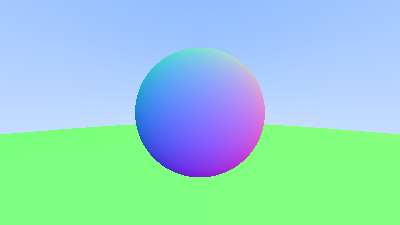

In [11]:
def ray_color(ray: Ray, world: HittableList) -> Color:
    hit, rec = world.hit(ray, 0, infinity)
    if hit:
        return Color((0.5 * (rec.normal + Color([1, 1, 1]))).vec)
    
    unit_direction = ray.direction.unit_vector()
    t = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])

def raytrace_pipeline(filename: str):
    aspect_ratio = 16.0 / 9.0
    image_width = 400

    image_height = int(image_width / aspect_ratio)
    if image_height < 1:
        image_height = 1

    world = HittableList()

    world.add(Sphere(Point3([0, 0, -1]), 0.5))
    world.add(Sphere(Point3([0, -100.5, -1]), 100))


    viewport_height = 2.0
    viewport_width = viewport_height * (image_width / image_height)
    focal_length = 1.0
    camera_center = Point3([0, 0, 0])

    viewport_u = Vec3([viewport_width, 0, 0])
    viewport_v = Vec3([0, -viewport_height, 0])

    pixel_delta_u = viewport_u / image_width
    pixel_delta_v = viewport_v / image_height

    # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
    # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

    viewport_upper_left = camera_center - Vec3([0, 0, focal_length]) - (viewport_u / 2) - (viewport_v / 2)
    pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)
    # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.


    # CRIAR MATRIZ
    image = Image(image_width, image_height)
    for j in tqdm(range(image_height)):
        for i in range(image_width):
            pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
            ray_direction = pixel_center - camera_center
            ray = Ray(camera_center, ray_direction)

            pixel_color = ray_color(ray, world)
            image[j, i] = pixel_color

    img_writer = ImageWriter(image)
    img_writer.save(filename)
    display(img_writer.image)

raytrace_pipeline('5-first-world.png')
# A imagem sairá com degradê para os dois lados, pois está utilizando o vetor unidade, e não o próprio y diretamente
# Logo, as outras coordenadas (x e z) influenciam no vetor unidade, fazendo com que o y não seja o unico vetor que influencia na cor.

## 6.8 An Interval Class

In [12]:
class Interval:

    def __init__(self, min: float, max: float):
        self.min = min
        self.max = max

    def __contains__(self, value: float):
        return self.min <= value <= self.max
    
    def surrounds(self, value: float):
        return self.min <= value <= self.max

In [13]:
class Hittable:

    def hit(self, ray: Ray, t_interval: Interval) -> "tuple[bool, HitRecord]":
        raise NotImplementedError('Esse método método deve ser implementado na classe filha.')

In [14]:
class Sphere(Hittable):

    def __init__(self, center: Point3, radius: float):
        self.__center = center
        self.__radius = radius
    
    @property
    def center(self):
        return self.__center
    
    @property
    def radius(self):
        return self.__radius

    def hit(self, ray: Ray, t_interval: Interval) -> "tuple[bool, HitRecord]":
        oc = ray.origin - self.center
        a = ray.direction.squared_length()
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius ** 2

        discriminant = half_b ** 2 - a * c

        if discriminant < 0:
            return False, None
        else:
            root = np.sqrt(discriminant)
            t = (-half_b - root) / a
            if t not in t_interval:
                t = (-half_b + root) / a
                if t not in t_interval:
                    return False, None
            
            p = ray.at(t)
            normal = (p - self.center) / self.radius
            return True, HitRecord(p, normal, t, ray)

In [15]:
class HittableList:
    
    def __init__(self):
        self.objects: list[Hittable] = []
    
    def add(self, obj: Hittable):
        self.objects.append(obj)
    
    def clear(self):
        self.objects.clear()
    
    def hit(self, ray: Ray, interval: Interval) -> "tuple[bool, HitRecord]":
        hit_anything = False
        closest_so_far = interval.max
        for obj in self.objects:
            hit, rec = obj.hit(ray, Interval(interval.min, closest_so_far))
            if hit:
                hit_anything = True
                closest_so_far = rec.t
                hit_record = rec
        
        if hit_anything:
            return True, hit_record
        else:
            return False, None

100%|██████████| 225/225 [00:16<00:00, 13.79it/s]


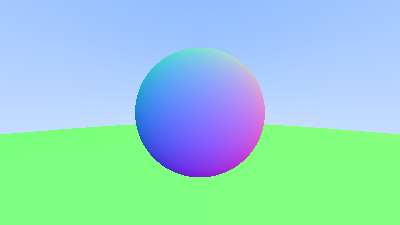

In [16]:
def ray_color(ray: Ray, world: HittableList) -> Color:
    hit, rec = world.hit(ray, Interval(0, infinity))
    if hit:
        return Color((0.5 * (rec.normal + Color([1, 1, 1]))).vec)
    
    unit_direction = ray.direction.unit_vector()
    t = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])

raytrace_pipeline('6-first-world-with-interval.png')

## 7 Moving Camera Code Into Its Own Class

In [17]:
class Camera:

    def initialize(self):
        self.aspect_ratio = 16.0 / 9.0
        self.image_width = 400

        self.image_height = int(image_width / aspect_ratio)
        if self.image_height < 1:
            self.image_height = 1

        self.viewport_height = 2.0
        self.viewport_width = self.viewport_height * (image_width / image_height)
        self.focal_length = 1.0
        self.camera_center = Point3([0, 0, 0])

        self.viewport_u = Vec3([self.viewport_width, 0, 0])
        self.viewport_v = Vec3([0, -self.viewport_height, 0])

        self.pixel_delta_u = self.viewport_u / self.image_width
        self.pixel_delta_v = self.viewport_v / self.image_height

        # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
        # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

        self.viewport_upper_left = self.camera_center - Vec3([0, 0, self.focal_length]) - (self.viewport_u / 2) - (self.viewport_v / 2)
        self.pixel00_loc = self.viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)
        # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.

    def ray_color(self, ray: Ray, world: HittableList) -> Color:
        hit, rec = world.hit(ray, Interval(0, infinity))
        if hit:
            return Color((0.5 * (rec.normal + Color([1, 1, 1]))).vec)
        
        unit_direction = ray.direction.unit_vector()
        t = 0.5 * (unit_direction.y + 1.0)
        return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])
    
    def render(self, world: HittableList, filename: str) -> Image:
        self.initialize()

        image = Image(self.image_width, self.image_height)
        for j in tqdm(range(self.image_height)):
            for i in range(self.image_width):
                self.pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
                self.ray_direction = self.pixel_center - self.camera_center
                ray = Ray(self.camera_center, self.ray_direction)

                pixel_color = ray_color(ray, world)
                image[j, i] = pixel_color

        img_writer = ImageWriter(image)
        img_writer.save(filename)
        display(img_writer.image)
        
        return image

100%|██████████| 225/225 [00:13<00:00, 17.04it/s]


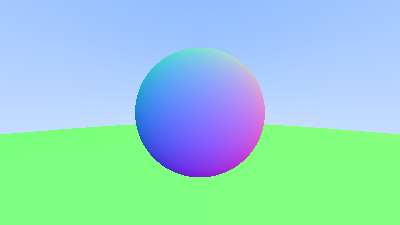

In [18]:
camera = Camera()

world = HittableList()
world.add(Sphere(Point3([0, 0, -1]), 0.5))
world.add(Sphere(Point3([0, -100.5, -1]), 100))

camera.render(world, '7-camera-class.png')

## 8.1 Some Random Number Utilities

In [19]:
import random

def random_double():
    return random.random()

def random_double_range(min: float, max: float):
    '''
    Gera um número aleatório entre min e max.

    ---

    Parâmetros:

        - min: float - Valor mínimo.
        - max: float - Valor máximo.
    
    ---

    Retorno:

        - float - Número aleatório entre min e max.
    '''
    return min + (max - min) * random_double()

## 8.2 Generating Pixels with Multiple Samples

In [20]:
class Interval:

    def __init__(self, min: float, max: float):
        self.min = min
        self.max = max

    def __contains__(self, value: float):
        return self.min <= value <= self.max
    
    def surrounds(self, value: float):
        return self.min <= value <= self.max

    def clamp(self, value: float):
        if value < self.min:
            return self.min
        if value > self.max:
            return self.max
        return value

In [21]:
def transform_color(pixel_color: Color, samples_per_pixel: int) -> Color:
    r = pixel_color.x
    g = pixel_color.y
    b = pixel_color.z

    scale = 1.0 / samples_per_pixel
    r *= scale
    g *= scale
    b *= scale

    intensity = Interval(0.000, 0.999)

    return Color([intensity.clamp(r), intensity.clamp(g), intensity.clamp(b)])

In [22]:
class Camera:

    def initialize(self):
        self.aspect_ratio = 16.0 / 9.0
        self.image_width = 400
        self.samples_per_pixel = 100

        self.image_height = int(image_width / aspect_ratio)
        if self.image_height < 1:
            self.image_height = 1

        self.viewport_height = 2.0
        self.viewport_width = self.viewport_height * (image_width / image_height)
        self.focal_length = 1.0
        self.camera_center = Point3([0, 0, 0])

        self.viewport_u = Vec3([self.viewport_width, 0, 0])
        self.viewport_v = Vec3([0, -self.viewport_height, 0])

        self.pixel_delta_u = self.viewport_u / self.image_width
        self.pixel_delta_v = self.viewport_v / self.image_height

        # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
        # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

        self.viewport_upper_left = self.camera_center - Vec3([0, 0, self.focal_length]) - (self.viewport_u / 2) - (self.viewport_v / 2)
        self.pixel00_loc = self.viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)
        # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.

    def ray_color(self, ray: Ray, world: HittableList) -> Color:
        hit, rec = world.hit(ray, Interval(0, infinity))
        if hit:
            return Color((0.5 * (rec.normal + Color([1, 1, 1]))).vec)
        
        unit_direction = ray.direction.unit_vector()
        t = 0.5 * (unit_direction.y + 1.0)
        return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])
    
    def render(self, world: HittableList, filename: str) -> Image:
        self.initialize()

        image = Image(self.image_width, self.image_height)
        for j in tqdm(range(self.image_height)):
            for i in range(self.image_width):
                # MUDOU AQUI
                pixel_color = Color([0, 0, 0])
                for sample in range(self.samples_per_pixel):
                    ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(ray, world)
                image[j, i] = transform_color(pixel_color, self.samples_per_pixel)

        img_writer = ImageWriter(image)
        img_writer.save(filename)
        display(img_writer.image)
        
        return image

    # NOVO MÉTODO
    def get_ray(self, i: int, j: int) -> Ray:
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()
        
        return Ray(self.camera_center, pixel_sample - self.camera_center)

    #NOVO MÉTODO
    def pixel_sample_square(self) -> Vec3:
        px = -0.5 + random_double()
        py = -0.5 + random_double()
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)

In [23]:
camera = Camera()

world = HittableList()
world.add(Sphere(Point3([0, 0, -1]), 0.5))
world.add(Sphere(Point3([0, -100.5, -1]), 100))

# camera.render(world, '8-antialiased.png')

## 9.1 A Simple Diffuse Material + 9.2 Limiting the Number of Child Rays

In [24]:
from Atividade02.src.vectorized.Vec import Vec
from typing import Union

class Vec3(Vec):
    """
    .. automethod:: __neg__
    .. automethod:: __getitem__
    .. automethod:: __add__
    .. automethod:: __sub__
    .. automethod:: __mul__
    .. automethod:: __truediv__
    .. automethod:: __iadd__
    .. automethod:: __isub__
    .. automethod:: __imul__
    .. automethod:: __itruediv__
    .. automethod:: __repr__
    
    """

    def __init__(self, vector: Union[np.ndarray, list] = np.zeros((3,), dtype=np.float64)):
        '''
        Construtor da classe Vec3. Recebe as coordenadas x, y e z do vetor.

        --- 

        Parâmetros:

            - vector: Union[np.ndarray, list] - Vetor ou lista contendo as coordenadas x, y e z do vetor.
        '''
        super().__init__(vector, (3,))
    
    @property
    def x(self) -> np.float64:
        '''
        Coordenada x do vetor.
        '''
        return self.vec[0]
    
    @x.setter
    def x(self, value: np.float64):
        self.vec[0] = value
    
    @property
    def y(self) -> np.float64:
        '''
        Coordenada y do vetor.
        '''
        return self.vec[1]
    
    @y.setter
    def y(self, value: np.float64):
        self.vec[1] = value

    @property
    def z(self) -> np.float64:
        '''
        Coordenada z do vetor.
        '''
        return self.vec[2]

    @z.setter
    def z(self, value: np.float64):
        self.vec[2] = value
    

    def __neg__(self) -> 'Vec3':
        '''
        Inverte o sinal de todas as coordenadas do vetor.

        Exemplo:

        >>> v = Vec3([1, 2, 3])
        >>> print(-v)
        -1.0 -2.0 -3.0

        ---

        Retorno:

            - Vec3 - Versão negativa do vetor.
        '''
        return super().__neg__()
    
    def __getitem__(self, key: int) -> np.float64:
        '''
        Retorna a coordenada do vetor de acordo com o índice.

        Exemplo:

        >>> v = Vec3([1, 2, 3])
        >>> print(v[0])
        1.0

        ---

        Parâmetros:
            
            - key: int - Índice da coordenada do vetor (0 = x, y = 1 e z = 2).

        ---

        Retorno:
            
            - np.float64 - Valor da coordenada escolhida.
        '''
        return super().__getitem__(key)
    

    def __add__(self, other: Union['Vec3', np.float64]) -> 'Vec3':
        '''
        Soma elemento a elemento de dois vetores. Ou soma um número a cada elemento do vetor.

        Exemplo:

        Somando dois vetores

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> print(v1 + v2)
        5.0 7.0 9.0

        Somando um vetor e um número:

        >>> v1 = Vec3([1, 2, 3])
        >>> print(v1 + 1)
        2.0 3.0 4.0

        ---

        Parâmetros:

            - other: Union['Vec3', np.float64] - Vetor ou número a ser somado.
        
        ---

        Retorno:

            - Vec3 - Resultado da soma.

        '''
        return super().__add__(other)
    
    def __sub__(self, other: Union['Vec3', np.float64]) -> 'Vec3':
        '''
        Subtrai elemento a elemento de dois vetores. Ou subtrai um número a cada elemento do vetor.

        Exemplo:

        Subtraindo dois vetores:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> print(v1 - v2)
        -3.0 -3.0 -3.0

        Subtraindo um vetor e um número:

        >>> v1 = Vec3([1, 2, 3])
        >>> print(v1 - 1)
        0.0 1.0 2.0

        ---

        Parâmetros:

            - other: Union['Vec3', np.float64] - Vetor ou número a ser subtraído.

        ---

        Retorno:
            
                - Vec3 - Resultado da subtração.
        
        '''
        return super().__sub__(other)
    
    def __mul__(self, other: Union['Vec3', np.float64]) -> 'Vec3':
        '''
        Multiplica elemento a elemento de dois vetores. Ou multiplica um número a cada elemento do vetor.

        Exemplo:

        Multiplicando dois vetores:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> print(v1 * v2)
        4.0 10.0 18.0

        Multiplicando um vetor e um número:

        >>> v1 = Vec3([1, 2, 3])
        >>> print(v1 * 2)
        2.0 4.0 6.0

        ---

        Parâmetros:

            - other: Union['Vec3', np.float64] - Vetor ou número a ser multiplicado.
        
        ---

        Retorno:

            - Vec3 - Resultado da multiplicação.
        '''
        return super().__mul__(other)
    
    def __truediv__(self, other: Union['Vec3', np.float64]) -> 'Vec3':
        '''
        Divide elemento a elemento de dois vetores. Ou divide um número a cada elemento do vetor.

        Exemplo:

        Dividindo dois vetores:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> print(v1 / v2)
        0.25 0.4 0.5

        Dividindo um vetor e um número:

        >>> v1 = Vec3([1, 2, 3])
        >>> print(v1 / 2)
        0.5 1.0 1.5

        ---

        Parâmetros:

            - other: Union['Vec3', np.float64] - Vetor ou número a ser utilizado como divisor.

        ---

        Retorno:

            - Vec3 - Resultado da divisão.
        '''
        return super().__truediv__(other)


    def __iadd__(self, other: Union['Vec3', np.float64]) -> 'Vec3':
        '''
        Soma elemento a elemento de dois vetores. Ou soma um número a cada elemento do vetor.

        Exemplo:

        Somando dois vetores:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> v1 += v2
        >>> print(v1)
        5.0 7.0 9.0

        Somando um vetor e um número:

        >>> v1 = Vec3([1, 2, 3])
        >>> v1 += 1
        >>> print(v1)
        2.0 3.0 4.0

        ---

        Parâmetros:

            - other: Union['Vec3', np.float64] - Vetor ou número a ser somado.
        
        ---

        Retorno:

            - Vec3 - Resultado da soma.
        '''
        return super().__iadd__(other)
    
    def __isub__(self, other: Union['Vec3', np.float64]) -> 'Vec3':
        '''
        Subtrai elemento a elemento de dois vetores. Ou subtrai um número a cada elemento do vetor.

        Exemplo:

        Subtraindo dois vetores:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> v1 -= v2
        >>> print(v1)
        -3.0 -3.0 -3.0

        Subtraindo um vetor e um número:

        >>> v1 = Vec3([1, 2, 3])
        >>> v1 -= 1
        >>> print(v1)
        0.0 1.0 2.0

        ---

        Parâmetros:

            - other: Union['Vec3', np.float64] - Vetor ou número a ser subtraído.
        
        ---

        Retorno:

            - Vec3 - Resultado da subtração.
        '''
        return super().__isub__(other)
    
    def __imul__(self, other: Union['Vec3', np.float64]) -> 'Vec3':
        '''
        Multiplica elemento a elemento de dois vetores. Ou multiplica um número a cada elemento do vetor.

        Exemplo:

        Multiplicando dois vetores:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> v1 *= v2
        >>> print(v1)
        4.0 10.0 18.0

        Multiplicando um vetor e um número:

        >>> v1 = Vec3([1, 2, 3])
        >>> v1 *= 2
        >>> print(v1)
        2.0 4.0 6.0

        ---

        Parâmetros:

            - other: Union['Vec3', np.float64] - Vetor ou número a ser multiplicado.
        
        ---

        Retorno:

            - Vec3 - Resultado da multiplicação.
        '''
        return super().__imul__(other)

    def __itruediv__(self, other: Union['Vec3', np.float64]) -> 'Vec3':
        '''
        Divide elemento a elemento de dois vetores. Ou divide um número a cada elemento do vetor.

        Exemplo:

        Dividindo dois vetores:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> v1 /= v2
        >>> print(v1)
        0.25 0.4 0.5

        Dividindo um vetor e um número:

        >>> v1 = Vec3([1, 2, 3])
        >>> v1 /= 2
        >>> print(v1)
        0.5 1.0 1.5

        ---

        Parâmetros:

            - other: Union['Vec3', np.float64] - Vetor ou número a ser dividido.
        
        ---

        Retorno:

            - Vec3 - Resultado da divisão.
        '''
        return super().__itruediv__(other)
    
    def __repr__(self) -> str:
        '''
        Retorna uma string representando o vetor.

        A string é composta pelas coordenadas x, y e z do vetor, separadas por um espaço.

        Exemplo:

        >>> v = Vec3([1, 2, 3])
        >>> print(v)
        1.0 2.0 3.0
        '''
        return f"{self.vec[0]} {self.vec[1]} {self.vec[2]}"
    
    
    def length(self) -> np.float64:
        '''
        Retorna o comprimento do vetor.

        Exemplo:

        >>> v = Vec3([1, 2, 3])
        >>> print(v.length())  # sqrt(1 ** 2 + 2 ** 2 + 3 ** 2)
        3.7416573867739413
        '''
        return super().length()
    
    def squared_length(self) -> np.float64:
        '''
        Retorna o comprimento do vetor ao quadrado.

        Exemplo:

        >>> v = Vec3([1, 2, 3])
        >>> print(v.squared_length())  # 1 ** 2 + 2 ** 2 + 3 ** 2
        14.0
        '''
        return super().squared_length()
    
    def dot(self, other: 'Vec3') -> np.float64:
        '''
        Retorna o produto escalar entre dois vetores.

        Exemplo:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> print(v1.dot(v2))
        32.0

        ---

        Parâmetros:

            - other: 'Vec3' - Segundo vetor do produto escalar.
        
        ---

        Retorno:
            
            - np.float64 - Resultado do produto escalar.
        '''
        return super().dot(other)
    
    def cross(self, other: 'Vec3') -> 'Vec3':
        '''
        Retorna o produto vetorial entre dois vetores.

        Exemplo:

        >>> v1 = Vec3([1, 2, 3])
        >>> v2 = Vec3([4, 5, 6])
        >>> print(v1.cross(v2))
        -3.0 6.0 -3.0

        ---

        Parâmetros:

            - other: 'Vec3' - Segundo vetor do produto vetorial.
        
        ---

        Retorno:

            - Vec3 - Resultado do produto vetorial.
        '''
        if not isinstance(other, Vec3):
            raise TypeError(f"Tipo inválido para produto vetorial, esperado: Vec2, recebido: {type(other)}")
        
        return Vec3([self.vec[1] * other.vec[2] - self.vec[2] * other.vec[1],
                    self.vec[2] * other.vec[0] - self.vec[0] * other.vec[2],
                    self.vec[0] * other.vec[1] - self.vec[1] * other.vec[0]])
    
    def unit_vector(self) -> 'Vec3':
        '''
        Retorna o vetor unitário.

        Exemplo:

        >>> v = Vec3([1, 2, 3])
        >>> print(v.unit_vector())
        0.27 0.53 0.80

        ---

        Retorno:

            - Vec3 - Vetor unitário.
        '''
        return super().unit_vector()
    
    @staticmethod
    def random() -> Vec3:
        '''
        Retorna um vetor com coordenadas aleatórias entre 0 e 1.

        Exemplo:

        >>> print(Vec3.random())
        0.73 0.71 0.60

        ---

        Retorno:

            - Vec3 - Vetor com coordenadas aleatórias.
        '''
        return Vec3([random_double(), random_double(), random_double()])
    
    @staticmethod
    def random_range(min: float, max: float) -> Vec3:
        '''
        Retorna um vetor com coordenadas aleatórias entre min e max.

        Exemplo:

        >>> print(Vec3.random_range(0, 10))
        7.73 1.71 6.60

        ---

        Parâmetros:

            - min: float - Valor mínimo das coordenadas.
            - max: float - Valor máximo das coordenadas.
        
        ---

        Retorno:

            - Vec3 - Vetor com coordenadas aleatórias.
        '''
        return Vec3([random_double_range(min, max), random_double_range(min, max), random_double_range(min, max)])
    
    # Não entendi o motivo de ficar sorteando várias vezes, pq não só sortear um e depois fazer o unitário (e talvez dividir ?)
    # Talvez seja para não enviesar a probalidade (aumentando a probabilidade) de sair um vetor unitário em direção a um
    # do cantos do cubo, já que a probabilidade disso acontecer é maior.
    @staticmethod
    def random_in_unit_sphere() -> Vec3:
        '''
        Retorna um vetor aleatório dentro da esfera unitária.

        Exemplo:

        >>> print(Vec3.random_in_unit_sphere())
        0.73 0.71 0.60

        ---

        Retorno:

            - Vec3 - Vetor aleatório dentro da esfera unitária.
        '''
        while True:
            p = Vec3.random_range(-1, 1)
            if p.squared_length() >= 1:
                continue
            return p

    @staticmethod
    def random_unit_vector() -> Vec3:
        '''
        Retorna um vetor aleatório unitário.

        Exemplo:

        >>> print(Vec3.random_unit_vector())
        0.73 0.71 0.60

        ---

        Retorno:

            - Vec3 - Vetor aleatório unitário.
        '''
        return Vec3.random_in_unit_sphere().unit_vector()
    
    @staticmethod
    def random_on_hemisphere(normal: 'Vec3') -> Vec3:
        '''
        Retorna um vetor aleatório na hemisfério do vetor normal.

        Exemplo:

        >>> print(Vec3.random_on_hemisphere(Vec3([0, 1, 0])))
        0.73 0.71 0.60

        ---

        Parâmetros:

            - normal: 'Vec3' - Vetor normal.
        
        ---

        Retorno:

            - Vec3 - Vetor aleatório na hemisfério do vetor normal.
        '''
        in_unit_sphere = Vec3.random_in_unit_sphere()
        if in_unit_sphere.dot(normal) > 0.0:
            return in_unit_sphere
        else:
            return -in_unit_sphere
    
    def near_zero(self) -> bool:
        '''
        Retorna Verdadeiro se todos os elementos (x,y,z) do vetor são próximos de zero.
        
        ---

        Retorno:

            - bool - Se o vetor é próximo de zero.
        '''
        s = 1e-8
        return (abs(self.vec[0]) < s) and (abs(self.vec[1]) < s) and (abs(self.vec[2]) < s)
    
    @staticmethod
    def reflect(v: 'Vec3', n: 'Vec3') -> 'Vec3':
        '''
        Retorna o vetor refletido.

        Exemplo:

        >>> print(Vec3.reflect(Vec3([1, 2, 3]), Vec3([0, 1, 0])))
        1.00 -2.00 3.00

        ---

        Parâmetros:

            - v: 'Vec3' - Vetor a ser refletido.
            
            - n: 'Vec3' - Vetor normal.
        
        ---

        Retorno:

            - Vec3 - Vetor refletido.
        '''
        return v - 2 * v.dot(n) * n


In [25]:
class Camera:

    def __init__(self, image_width: int = 400, samples_per_pixel: int = 100, max_depth: int = 10):
        self.image_width = image_width
        self.samples_per_pixel = samples_per_pixel
        self.max_depth = max_depth

    def initialize(self):
        self.aspect_ratio = 16.0 / 9.0

        self.image_height = int(self.image_width / self.aspect_ratio)
        if self.image_height < 1:
            self.image_height = 1

        self.viewport_height = 2.0
        self.viewport_width = self.viewport_height * (image_width / image_height)
        self.focal_length = 1.0
        self.camera_center = Point3([0, 0, 0])

        self.viewport_u = Vec3([self.viewport_width, 0, 0])
        self.viewport_v = Vec3([0, -self.viewport_height, 0])

        self.pixel_delta_u = self.viewport_u / self.image_width
        self.pixel_delta_v = self.viewport_v / self.image_height

        # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
        # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

        self.viewport_upper_left = self.camera_center - Vec3([0, 0, self.focal_length]) - (self.viewport_u / 2) - (self.viewport_v / 2)
        self.pixel00_loc = self.viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)
        # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.

    def ray_color(self, ray: Ray, depth: int, world: HittableList) -> Color:
        if depth <= 0:
            return Color([0, 0, 0])

        hit, rec = world.hit(ray, Interval(0, infinity))
        if hit:
            direction = Vec3.random_on_hemisphere(rec.normal)
            return 0.5 * self.ray_color(Ray(rec.p, direction), depth - 1, world)
        
        unit_direction = ray.direction.unit_vector()
        t = 0.5 * (unit_direction.y + 1.0)
        return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])
    
    def render(self, world: HittableList, filename: str) -> Image:
        self.initialize()

        image = Image(self.image_width, self.image_height)
        for j in tqdm(range(self.image_height)):
            for i in range(self.image_width):
                # MUDOU AQUI
                pixel_color = Color([0, 0, 0])
                for _ in range(self.samples_per_pixel):
                    ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(ray, self.max_depth, world)
                image[j, i] = transform_color(pixel_color, self.samples_per_pixel)

        img_writer = ImageWriter(image)
        img_writer.save(filename)
        display(img_writer.image)
        
        return image

    # NOVO MÉTODO
    def get_ray(self, i: int, j: int) -> Ray:
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()
        
        return Ray(self.camera_center, pixel_sample - self.camera_center)

    #NOVO MÉTODO
    def pixel_sample_square(self) -> Vec3:
        px = -0.5 + random_double()
        py = -0.5 + random_double()
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)

In [26]:
camera = Camera()

world = HittableList()
world.add(Sphere(Point3([0, 0, -1]), 0.5))
world.add(Sphere(Point3([0, -100.5, -1]), 100))

# camera.render(world, '9-first-difuse.png')

100%|██████████| 112/112 [02:28<00:00,  1.33s/it]


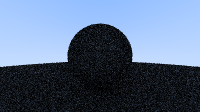

In [27]:
camera = Camera(image_width=200, samples_per_pixel=10, max_depth=10)

world = HittableList()
world.add(Sphere(Point3([0, 0, -1]), 0.5))
world.add(Sphere(Point3([0, -100.5, -1]), 100))

camera.render(world, '10-simplified-difuse.png')

## 9.3 Fixing Shadow Acne

In [28]:
class Camera:

    def __init__(self, image_width: int = 400, samples_per_pixel: int = 100, max_depth: int = 10):
        self.image_width = image_width
        self.samples_per_pixel = samples_per_pixel
        self.max_depth = max_depth

    def initialize(self):
        self.aspect_ratio = 16.0 / 9.0

        self.image_height = int(self.image_width / self.aspect_ratio)
        if self.image_height < 1:
            self.image_height = 1

        self.viewport_height = 2.0
        self.viewport_width = self.viewport_height * (image_width / image_height)
        self.focal_length = 1.0
        self.camera_center = Point3([0, 0, 0])

        self.viewport_u = Vec3([self.viewport_width, 0, 0])
        self.viewport_v = Vec3([0, -self.viewport_height, 0])

        self.pixel_delta_u = self.viewport_u / self.image_width
        self.pixel_delta_v = self.viewport_v / self.image_height

        # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
        # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

        self.viewport_upper_left = self.camera_center - Vec3([0, 0, self.focal_length]) - (self.viewport_u / 2) - (self.viewport_v / 2)
        self.pixel00_loc = self.viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)
        # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.

    def ray_color(self, ray: Ray, depth: int, world: HittableList) -> Color:
        if depth <= 0:
            return Color([0, 0, 0])

        hit, rec = world.hit(ray, Interval(0.001, infinity))
        if hit:
            direction = Vec3.random_on_hemisphere(rec.normal)
            return 0.5 * self.ray_color(Ray(rec.p, direction), depth - 1, world)
        
        unit_direction = ray.direction.unit_vector()
        t = 0.5 * (unit_direction.y + 1.0)
        return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])
    
    def render(self, world: HittableList, filename: str) -> Image:
        self.initialize()

        image = Image(self.image_width, self.image_height)
        for j in tqdm(range(self.image_height)):
            for i in range(self.image_width):
                # MUDOU AQUI
                pixel_color = Color([0, 0, 0])
                for _ in range(self.samples_per_pixel):
                    ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(ray, self.max_depth, world)
                image[j, i] = transform_color(pixel_color, self.samples_per_pixel)

        img_writer = ImageWriter(image)
        img_writer.save(filename)
        display(img_writer.image)
        
        return image

    # NOVO MÉTODO
    def get_ray(self, i: int, j: int) -> Ray:
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()
        
        return Ray(self.camera_center, pixel_sample - self.camera_center)

    #NOVO MÉTODO
    def pixel_sample_square(self) -> Vec3:
        px = -0.5 + random_double()
        py = -0.5 + random_double()
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)

100%|██████████| 112/112 [00:54<00:00,  2.05it/s]


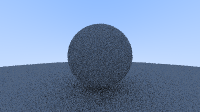

In [29]:
camera = Camera(image_width=200, samples_per_pixel=10, max_depth=10)

world = HittableList()
world.add(Sphere(Point3([0, 0, -1]), 0.5))
world.add(Sphere(Point3([0, -100.5, -1]), 100))

camera.render(world, '11-no-acne-simplified-difuse.png')

## 9.4 True Lambertian Reflection

In [30]:
class Camera:

    def __init__(self, image_width: int = 400, samples_per_pixel: int = 100, max_depth: int = 10):
        self.image_width = image_width
        self.samples_per_pixel = samples_per_pixel
        self.max_depth = max_depth

    def initialize(self):
        self.aspect_ratio = 16.0 / 9.0

        self.image_height = int(self.image_width / self.aspect_ratio)
        if self.image_height < 1:
            self.image_height = 1

        self.viewport_height = 2.0
        self.viewport_width = self.viewport_height * (image_width / image_height)
        self.focal_length = 1.0
        self.camera_center = Point3([0, 0, 0])

        self.viewport_u = Vec3([self.viewport_width, 0, 0])
        self.viewport_v = Vec3([0, -self.viewport_height, 0])

        self.pixel_delta_u = self.viewport_u / self.image_width
        self.pixel_delta_v = self.viewport_v / self.image_height

        # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
        # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

        self.viewport_upper_left = self.camera_center - Vec3([0, 0, self.focal_length]) - (self.viewport_u / 2) - (self.viewport_v / 2)
        self.pixel00_loc = self.viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)
        # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.

    def ray_color(self, ray: Ray, depth: int, world: HittableList) -> Color:
        if depth <= 0:
            return Color([0, 0, 0])

        hit, rec = world.hit(ray, Interval(0.001, infinity))
        if hit:
            direction = rec.normal + Vec3.random_unit_vector()
            return 0.5 * self.ray_color(Ray(rec.p, direction), depth - 1, world)
        
        unit_direction = ray.direction.unit_vector()
        t = 0.5 * (unit_direction.y + 1.0)
        return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])
    
    def render(self, world: HittableList, filename: str) -> Image:
        self.initialize()

        image = Image(self.image_width, self.image_height)
        for j in tqdm(range(self.image_height)):
            for i in range(self.image_width):
                # MUDOU AQUI
                pixel_color = Color([0, 0, 0])
                for _ in range(self.samples_per_pixel):
                    ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(ray, self.max_depth, world)
                image[j, i] = transform_color(pixel_color, self.samples_per_pixel)

        img_writer = ImageWriter(image)
        img_writer.save(filename)
        display(img_writer.image)
        
        return image

    # NOVO MÉTODO
    def get_ray(self, i: int, j: int) -> Ray:
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()
        
        return Ray(self.camera_center, pixel_sample - self.camera_center)

    #NOVO MÉTODO
    def pixel_sample_square(self) -> Vec3:
        px = -0.5 + random_double()
        py = -0.5 + random_double()
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)

  0%|          | 0/112 [00:00<?, ?it/s]

100%|██████████| 112/112 [01:01<00:00,  1.83it/s]


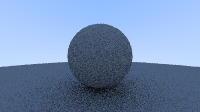

In [31]:
camera = Camera(image_width=200, samples_per_pixel=10, max_depth=10)

world = HittableList()
world.add(Sphere(Point3([0, 0, -1]), 0.5))
world.add(Sphere(Point3([0, -100.5, -1]), 100))

camera.render(world, '12-lambertian.png')

## 9.5 Using Gamma Correction for Accurate Color Intensity

In [32]:
from math import sqrt

def linear_to_gamma(linear_component: float) -> float:
    return sqrt(linear_component)

def transform_color(pixel_color: Color, samples_per_pixel: int) -> Color:
    r = pixel_color.x
    g = pixel_color.y
    b = pixel_color.z

    scale = 1.0 / samples_per_pixel
    r *= scale
    g *= scale
    b *= scale

    r = linear_to_gamma(r)
    g = linear_to_gamma(g)
    b = linear_to_gamma(b)

    intensity = Interval(0.000, 0.999)

    return Color([intensity.clamp(r), intensity.clamp(g), intensity.clamp(b)])

100%|██████████| 112/112 [00:50<00:00,  2.23it/s]


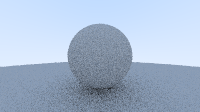

In [33]:
camera = Camera(image_width=200, samples_per_pixel=10, max_depth=10)

world = HittableList()
world.add(Sphere(Point3([0, 0, -1]), 0.5))
world.add(Sphere(Point3([0, -100.5, -1]), 100))

camera.render(world, '13-linear-to-gamma.png')

## 10.1 An Abstract Class for Materials

In [34]:
class Material:
    def scatter(self, ray: Ray, rec: HitRecord) -> 'tuple[bool, Ray, Color]':
        raise NotImplementedError

## 10.2 A Data Structure to Describe Ray-Object Intersections

In [35]:
class HitRecord:

    def __init__(self, p: Point3, normal: Vec3, t: float, ray: Ray, material: Material):
        self.material = material
        self.p = p
        self.t = t
        self.set_normal(normal, ray)
    
    def set_normal(self, outward_normal: Vec3, ray: Ray):
        self.front_face = ray.direction.dot(outward_normal) < 0
        self.normal = outward_normal if self.front_face else -outward_normal


In [42]:
# Não precisa colocar no HitRecord o material, pois o Python deixa ele ser adicionado dinamicamente

class Sphere(Hittable):

    def __init__(self, center: Point3, radius: float, material: Material):
        self.__material = material
        self.__center = center
        self.__radius = radius
    
    @property
    def center(self):
        return self.__center
    
    @property
    def radius(self):
        return self.__radius

    def hit(self, ray: Ray, t_interval: Interval) -> "tuple[bool, HitRecord]":
        '''
        Verifica se um raio atinge a esfera.

        ---

        Parâmetros:

            - ray: Ray - Raio a ser verificado.

            - t_interval: Interval - Intervalo de t em que o raio pode atingir a esfera.
        
        ---

        Retorno:

            - tuple[bool, HitRecord] - Tupla contendo um booleano que indica se o raio atingiu a esfera e um registro de acerto (hit record) com informações sobre o acerto. Caso o raio não atinja a esfera, o registro de acerto é None.
        '''
        oc = ray.origin - self.center
        a = ray.direction.squared_length()
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius ** 2

        discriminant = half_b ** 2 - a * c

        if discriminant < 0:
            return False, None
        else:
            root = np.sqrt(discriminant)
            t = (-half_b - root) / a
            if t not in t_interval:
                t = (-half_b + root) / a
                if t not in t_interval:
                    return False, None
            
            p = ray.at(t)
            normal = (p - self.center) / self.radius
            return True, HitRecord(p, normal, t, ray, self.__material)

## 10.3 Modeling Light Scatter and Reflectance

In [37]:
class Lambertian(Material):

    def __init__(self, albedo: Color):
        self.albedo = albedo
    
    def scatter(self, ray: Ray, rec: HitRecord) -> 'tuple[bool, Ray, Color]':
        direction: Vec3 = rec.normal + Vec3.random_unit_vector()
        if direction.near_zero():
            direction = rec.normal
        
        scattered = Ray(rec.p, direction)
        attenuation = self.albedo
        return True, scattered, attenuation

## 10.4 Mirrored Light Reflection

In [38]:
class Metal(Material):
    
    def __init__(self, albedo: Color):
        self.albedo = albedo
    
    def scatter(self, ray: Ray, rec: HitRecord) -> 'tuple[bool, Ray, Color]':
        reflected = Vec3.reflect(ray.direction.unit_vector(), rec.normal)
        scattered = Ray(rec.p, reflected)
        attenuation = self.albedo
        return True, scattered, attenuation

In [39]:
class Camera:

    def __init__(self, image_width: int = 400, samples_per_pixel: int = 100, max_depth: int = 10):
        self.image_width = image_width
        self.samples_per_pixel = samples_per_pixel
        self.max_depth = max_depth

    def initialize(self):
        self.aspect_ratio = 16.0 / 9.0

        self.image_height = int(self.image_width / self.aspect_ratio)
        if self.image_height < 1:
            self.image_height = 1

        self.viewport_height = 2.0
        self.viewport_width = self.viewport_height * (image_width / image_height)
        self.focal_length = 1.0
        self.camera_center = Point3([0, 0, 0])

        self.viewport_u = Vec3([self.viewport_width, 0, 0])
        self.viewport_v = Vec3([0, -self.viewport_height, 0])

        self.pixel_delta_u = self.viewport_u / self.image_width
        self.pixel_delta_v = self.viewport_v / self.image_height

        # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
        # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

        self.viewport_upper_left = self.camera_center - Vec3([0, 0, self.focal_length]) - (self.viewport_u / 2) - (self.viewport_v / 2)
        self.pixel00_loc = self.viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)
        # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.

    def ray_color(self, ray: Ray, depth: int, world: HittableList) -> Color:
        if depth <= 0:
            return Color([0, 0, 0])

        hit, rec = world.hit(ray, Interval(0.001, infinity))
        if hit:
            is_scatered, scattered, attenuation = rec.material.scatter(ray, rec)
            if is_scatered:
                return attenuation * self.ray_color(scattered, depth - 1, world)
            return Color([0, 0, 0])
        
        unit_direction = ray.direction.unit_vector()
        t = 0.5 * (unit_direction.y + 1.0)
        return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])
    
    def render(self, world: HittableList, filename: str) -> Image:
        self.initialize()

        image = Image(self.image_width, self.image_height)
        for j in tqdm(range(self.image_height)):
            for i in range(self.image_width):
                # MUDOU AQUI
                pixel_color = Color([0, 0, 0])
                for _ in range(self.samples_per_pixel):
                    ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(ray, self.max_depth, world)
                image[j, i] = transform_color(pixel_color, self.samples_per_pixel)

        img_writer = ImageWriter(image)
        img_writer.save(filename)
        display(img_writer.image)
        
        return image

    # NOVO MÉTODO
    def get_ray(self, i: int, j: int) -> Ray:
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()
        
        return Ray(self.camera_center, pixel_sample - self.camera_center)

    #NOVO MÉTODO
    def pixel_sample_square(self) -> Vec3:
        px = -0.5 + random_double()
        py = -0.5 + random_double()
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)

100%|██████████| 112/112 [02:03<00:00,  1.10s/it]


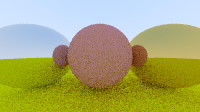

In [43]:
camera = Camera(image_width=200, samples_per_pixel=10, max_depth=10)

material_ground = Lambertian(Color([0.8, 0.8, 0.0]))
material_center = Lambertian(Color([0.7, 0.3, 0.3]))
material_left = Metal(Color([0.8, 0.8, 0.8]))
material_right = Metal(Color([0.8, 0.6, 0.2]))

world = HittableList()
world.add(Sphere(Point3([0, -100.5, -1]), 100, material_ground))
world.add(Sphere(Point3([0, 0, -1]), 0.5, material_center))
world.add(Sphere(Point3([-1, 0, -1]), 0.5, material_left))
world.add(Sphere(Point3([1, 0, -1]), 0.5, material_right))

camera.render(world, '14-first-metals.png')

## 10.6 Fuzzy Reflection

In [44]:
class Metal(Material):
    
    def __init__(self, albedo: Color, fuzz: float = 0.0):
        self.albedo = albedo
        self.fuzz = fuzz if fuzz < 1 else 1
    
    def scatter(self, ray: Ray, rec: HitRecord) -> 'tuple[bool, Ray, Color]':
        reflected = Vec3.reflect(ray.direction.unit_vector(), rec.normal)
        scattered = Ray(rec.p, reflected + self.fuzz * Vec3.random_in_unit_sphere())
        attenuation = self.albedo
        return scattered.direction.dot(rec.normal) > 0, scattered, attenuation

100%|██████████| 112/112 [02:14<00:00,  1.20s/it]


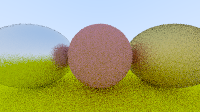

In [47]:
camera = Camera(image_width=200, samples_per_pixel=10, max_depth=10)

material_ground = Lambertian(Color([0.8, 0.8, 0.0]))
material_center = Lambertian(Color([0.7, 0.3, 0.3]))
material_left = Metal(Color([0.8, 0.8, 0.8]), fuzz=0.3)
material_right = Metal(Color([0.8, 0.6, 0.2]), fuzz=1)

world = HittableList()
world.add(Sphere(Point3([0, -100.5, -1]), 100, material_ground))
world.add(Sphere(Point3([0, 0, -1]), 0.5, material_center))
world.add(Sphere(Point3([-1, 0, -1]), 0.5, material_left))
world.add(Sphere(Point3([1, 0, -1]), 0.5, material_right))

camera.render(world, '15-fuzzed-metals.png')